In [46]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(0)

Download data

In [47]:
!gdown 1voaEt-fGwpU_02xV8EBbQvP60e-iuLV1

Downloading...
From (original): https://drive.google.com/uc?id=1voaEt-fGwpU_02xV8EBbQvP60e-iuLV1
From (redirected): https://drive.google.com/uc?id=1voaEt-fGwpU_02xV8EBbQvP60e-iuLV1&confirm=t&uuid=7b8fdc28-9ce8-4c1c-bd1c-49766004848b
To: /content/data.zip
100% 594M/594M [00:05<00:00, 100MB/s]


In [48]:
import zipfile

# Unzip the dataset
local_zip = './data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [49]:
!gdown 1MEiNJrszlXAEdnDQiALLn5MGQ4JZ2aI0

Downloading...
From: https://drive.google.com/uc?id=1MEiNJrszlXAEdnDQiALLn5MGQ4JZ2aI0
To: /content/upper_30.h5
100% 75.7M/75.7M [00:00<00:00, 107MB/s]


# Part 1: Transfer Learning

Let's return to the [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T) dataset, which we had trouble fitting from scratch. We'll see how weights from another computer vision model trained a lot more data can help us with this task.

## Data Augmentation

First, we'll set up `ImageDataGenerator`s to stream images.

**1. Pass at least 3 augmentation [arguments](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args) to the `ImageDataGenerator` to augment the data.**


In [50]:
batch_size = 25

base_dir = 'data/skin_cancer'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # YOUR CODE HERE (1)
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=40
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


## Feature extraction

First, we will import a [VGG16](https://arxiv.org/pdf/1409.1556.pdf%E3%80%82) CNN with weights pretrained on [ImageNet](https://image-net.org), a dataset with 1,000 object classes and more than a million training examples. We can leave the feedforward portion of the network out by specifying `include_top=False`. The convolutional layers should contain lower-level features that are also useful for our task.

In [51]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

We will use the `ImageDataGenerator` to generate augmented data, and we will extract features from those images by running the forward pass of `conv_base`.

We'll define a NumPy array `features` to contain the output of the `conv_base` model.

Then we'll define another NumPy array `labels` to contain the labels. Note thate the labels have "one hot" encodings, so the second dimension of the label array will be the number of classes.

Then, for each batch from the generator (`input_batch`), we will use the `predict` function of `conv_base` to generate features.

In [52]:
import numpy as np

def extract_features(img_generator, n_samples, model):

    features = np.zeros(shape=(n_samples, 4, 4, 512))
    labels = np.zeros(shape=(n_samples, 4))

    n_batches = n_samples // batch_size
    i = 0
    for input_batch, labels_batch in img_generator:
        print('Batch %d of %d'%(i+1, n_batches))

        features_batch = conv_base.predict(input_batch)

        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch

        # the generator will produce infinite, randomly
        # augmented images; break when we have enough
        i += 1
        if i == n_batches:
            break

    return features, labels

Extract training and validation features (this will take a few minutes). We will generate 4000 augmented training images (4 times the number of samples). The validation data is not augmented, so we will use the exact number of images that we have (1000).

In [53]:
train_features, train_labels = extract_features(train_generator, 4000, conv_base)

Batch 1 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
Batch 2 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Batch 3 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Batch 4 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Batch 5 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Batch 6 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Batch 7 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Batch 8 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Batch 9 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Batch 10 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Batch 11 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Batch 12 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Batch 13 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Batch 14 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Batch 15 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Batch 16 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Batch 17 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Batch 18 of 160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Batch 19 of 160
1/1

In [54]:
validation_features, validation_labels = extract_features(validation_generator, 1000, conv_base)

Batch 1 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Batch 2 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Batch 3 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Batch 4 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Batch 5 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Batch 6 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Batch 7 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Batch 8 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Batch 9 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Batch 10 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Batch 11 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Batch 12 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Batch 13 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Batch 14 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Batch 15 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Batch 16 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Batch 17 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Batch 18 of 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Batch 19 of 40
1/1 ━━━━━━━━━━━━━━━━━━

**2. Define a feed-forward network with one hidden layer of size 512 to predict the labels from our extracted convolutional features.**
  - Hint: remember that in a full CNN, a Flatten layer is used to prepare the output of the convolutional layers for feed-forward layers
  - Hint: be sure to specify the input shape; this can be done using an [InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer) or by simply passing `input_shape` to the first network layer.
  - Hint: ensure the output layer has the appropriate size and activation for this multiclass classification problem.

In [55]:
model = tf.keras.models.Sequential([
    #YOUR CODE HERE (2)
    tf.keras.layers.InputLayer(shape=(4, 4, 512)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

Let's compile and train the model (this will take a few minutes).

In [56]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])
history = model.fit(
      train_features,
      train_labels,
      epochs=10,
      validation_data=(validation_features, validation_labels),
      verbose=2)

Epoch 1/10
125/125 - 2s - 16ms/step - accuracy: 0.4320 - loss: 1.5916 - val_accuracy: 0.4060 - val_loss: 1.4022
Epoch 2/10
125/125 - 0s - 4ms/step - accuracy: 0.5430 - loss: 1.0626 - val_accuracy: 0.5180 - val_loss: 1.1121
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.5995 - loss: 0.9414 - val_accuracy: 0.6030 - val_loss: 0.9643
Epoch 4/10
125/125 - 1s - 4ms/step - accuracy: 0.6317 - loss: 0.8802 - val_accuracy: 0.5760 - val_loss: 1.0384
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.6695 - loss: 0.8151 - val_accuracy: 0.5920 - val_loss: 1.0417
Epoch 6/10
125/125 - 1s - 5ms/step - accuracy: 0.6910 - loss: 0.7575 - val_accuracy: 0.5780 - val_loss: 1.1232
Epoch 7/10
125/125 - 1s - 4ms/step - accuracy: 0.7122 - loss: 0.7090 - val_accuracy: 0.5170 - val_loss: 1.3990
Epoch 8/10
125/125 - 0s - 4ms/step - accuracy: 0.7258 - loss: 0.6688 - val_accuracy: 0.5740 - val_loss: 1.1058
Epoch 9/10
125/125 - 1s - 4ms/step - accuracy: 0.7542 - loss: 0.6233 - val_accuracy: 0.5620 - val_loss: 1.1183


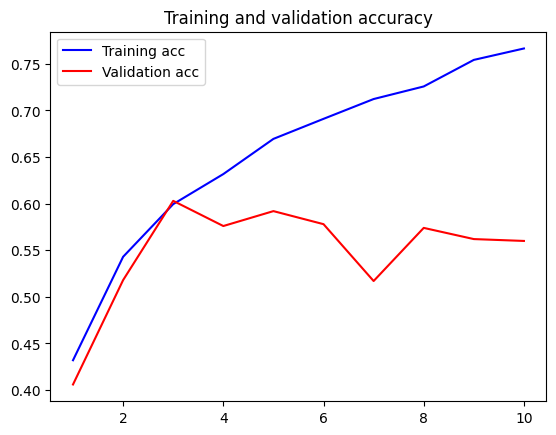

In [57]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

This model is doing much better than the Week 2 model, and was faster.

## Fine-tuning

Now, instead of extracting features and storing them, we will add the feedforward layers directly on top of the convolutional base. This will allow us to fine-tune the upper layers of the base. However, the feedforward layers will need to be partially trained first, or large errors will propagate to the pretrained convolutional weights, causing them to "forget" their features entirely.

**3. Define a model that stacks the small feedforward classification network directly on top of `conv_base`.**
 - Hint: entire models can be added to `Sequential` just like they were layers.


In [58]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential([
    # YOUR CODE HERE (3)
    conv_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,911,556 (72.14 MB)

 Trainable params: 18,911,556 (72.14 MB)

 Non-trainable params: 0 (0.00 B)

We can see that our vgg16 "layer" is adding the majority of the ~19M trainable parameters.

**4. "Freeze" the weights of the vgg16 module (`conv_base`) so we can train only the dense layers.**
 - Hint: you can freeze a layer or model by setting its [`trainable`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#attributes_1) attribute.

In [60]:
# YOUR CODE HERE (4)
conv_base.trainable=False

In [61]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,911,556 (72.14 MB)

 Trainable params: 4,196,868 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Most of the parameters are now "non-trainable," meaning they are frozen and will not be updated via backpropagation. Let's train the upper layers. These epochs will take much longer than the feature extraction method, since the entire forward pass of the network needs to be computed for each sample, even though most of the layers are frozen.

In [62]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])
history = model.fit(
      train_generator,
      epochs=1,
      validation_data=validation_generator,
      verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 - 22s - 547ms/step - accuracy: 0.3420 - loss: 2.1640 - val_accuracy: 0.4350 - val_loss: 1.4868


Let's fast-forward a bit. We'll load some weights that have trained for 30 epochs.

**5. Load weights from the "upper_30.h5" archive file.**

  - Hint: use the `model` [`load_weights`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#load_weights) method.

In [63]:
# YOUR CODE HERE (5)
model.load_weights('upper_30.h5')

In [64]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,108,426 (88.15 MB)

 Trainable params: 4,196,868 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,196,870 (16.01 MB)

In [65]:
### extra code block
# i couldn't figure out the code block names.... -JU
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


Now we will fine-tune convolutional layers to make their weights more specific to our data. However, the lower layers likely encode basic features like edges and patterns that we will not need to change. We will only fine-tune the last convolutional block, "block 5," which may be much more specific to the objects in ImageNet.

Note that to unfreeze specific layers, we will need to unfreeze the whole module and then re-freeze all layers not in block 5.

**6. Freeze all layers not in block 5.**
 - Hint: use the `name` property of `layer`.
 - Hint: refer to the model summary above to find the names of layers in block 5.

In [66]:
conv_base.trainable=True
for layer in conv_base.layers:
    # YOUR CODE HERE (6)
    if layer.name not in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']:
        layer.trainable=False

In [67]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,108,426 (88.15 MB)

 Trainable params: 11,276,292 (43.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 4,196,870 (16.01 MB)

Now we will compile and fit with a lower learning rate (this will take a few minutes).

In [68]:
tf.__version__

'2.18.0'

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator,
      verbose=2)

Epoch 1/5
40/40 - 25s - 623ms/step - accuracy: 0.5030 - loss: 1.3448 - val_accuracy: 0.4970 - val_loss: 1.0794
Epoch 2/5
40/40 - 19s - 485ms/step - accuracy: 0.5930 - loss: 0.9792 - val_accuracy: 0.6220 - val_loss: 0.9108
Epoch 3/5
40/40 - 19s - 465ms/step - accuracy: 0.6300 - loss: 0.8678 - val_accuracy: 0.5860 - val_loss: 1.0890
Epoch 4/5
40/40 - 20s - 489ms/step - accuracy: 0.6520 - loss: 0.8427 - val_accuracy: 0.5880 - val_loss: 1.0586
Epoch 5/5
40/40 - 19s - 465ms/step - accuracy: 0.6760 - loss: 0.7873 - val_accuracy: 0.6050 - val_loss: 0.9737


In [70]:
type(validation_generator.samples//batch_size)

int

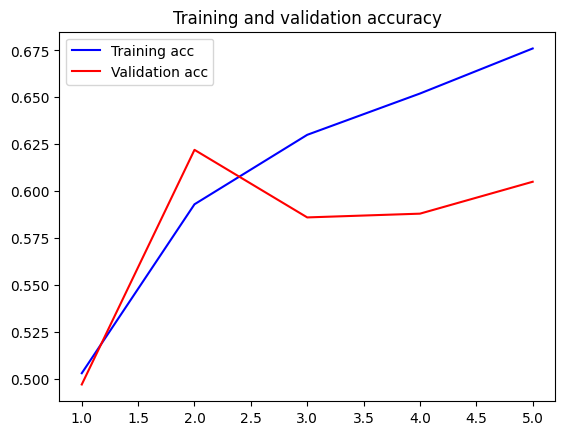

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

**7. Save the model weights to an archive called "fine_tune.weights.h5".**
  - Hint: use the `model` [`save_weights`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights) method.

In [72]:
# YOUR CODE HERE (7)
model.save_weights('fine_tune.weights.h5')

# Part 2: Hyperparameter optimization

In [73]:
!pip install -q -U keras-tuner

In [74]:
import keras_tuner as kt

**8. Define [hyperparameter](https://keras.io/api/keras_tuner/hyperparameters/) ranges to be explored by the [tuner](https://keras.io/api/keras_tuner/).**
  - **(1pt) `act`: Activation ('tanh' or 'relu')**
  - **(1pt) `drp`: Dropout (0.0 to 0.6, step of 0.2)**
  - **(1pt) `lrn`: Learning rate (0.001 to 0.1, log sampling)**
  - Hint: use the appropriate hyperparameter type (`Choice`, `Int`, etc.)
  - Hint: name the hyperparameter whatever is useful to identify in tuner output later

In [75]:
def build_model(hp):

    # YOUR CODE HERE (8)
    act = hp.Choice('activation', values=['tanh', 'relu'])
    drp = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.2)
    lrn = hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log')

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation=act, input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation=act),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation=act),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation=act),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=act),
        tf.keras.layers.Dropout(drp),
        tf.keras.layers.Dense(4, activation='softmax'),
    ])

    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=lrn),
              metrics=['accuracy'])

    return model

Search the hyperparameter ranges we have defined using Bayesian optimization (this will take a few minutes).

In [76]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5)

tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=1)

Reloading Tuner from ./untitled_project/tuner0.json


**9. Print the best value of each hyperparameter found by the tuner.**

  - Hint: See [`get_best_hyperparameters()`](https://keras.io/api/keras_tuner/tuners/base_tuner/#get_best_hyperparameters-method)
  - Hint: You can get the individual hyperparameters using the names you chose for them in step 8.

In [77]:
best=tuner.get_best_hyperparameters(1)[0]
print('Best activation:     ' + best.get('activation'))
print('Best dropout:        ' + str(best.get('dropout')))
print('Best learning rate : ' + str(best.get('learning_rate')))

Best activation:     tanh
Best dropout:        0.0
Best learning rate : 0.014624836934599253
